<a href="https://colab.research.google.com/github/lynxoo/ue-wroc-sad/blob/master/SAD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Statystyczna Analiza Danych
## Analiza Szkockich Whisky

Autorzy projektu:
* Łukasz Fąfara (179930)
* Artur Malarz (179337)

## Wstęp

Celem projektu jest przeprowadzenie klasteryzacji oraz analizy wybranych danych statystycznych. Przedmiotem badań poniższej analizy będzie zbiór ocen szkockiej whisky pozyskany z serwisu [Keggle](https://www.kaggle.com/koki25ando/22000-scotch-whisky-reviews) \(serwis danych źródłowych [Whisky Advocate](http://whiskyadvocate.com/)).

Zbiór zawiera następujące informacje na temat produktu:
- numer porządkowy
- nazwę
- kategorię
- średnią ocen jakości whisky (smaku) wystawioną przez recenzentów
- cenę jednostkową
- opis

Średnią ocenę jakości whisky serwis klasyfikuje następująco:
95-100 points—Classic: a great whisky  
90-94 points—Outstanding: a whisky of superior character and style  
85-89 points—Very good: a whisky with special qualities  
80-84 points—Good: a solid, well-made whisky  
75-79 points—Mediocre: a drinkable whisky that may have minor flaws  
50-74 points—Not recommended  

Większość rekordów zawiera także informacje na temat wieku danej whisky (czasu leżakowania) oraz zawartości alkoholu.

Dokonując analizy statystycznej zebranych danych, chcielibyśmy sprawdzić, czy whisky dostępne na rynku można skategoryzować względem jakości, ceny oraz zawartości alkoholu. Chcielibyśmy sprawdzić, które z tych parametrów mają na siebie wpływ, a także czy wiek whisky jest jego największą zaletą, która jednogłośnie dyktuje jego smak oraz cenę.

### Wstępna obróbka danych

Przed przystąpieniem do wstępnej obróbki, należało dokonać korekty pliku z danymi `.csv`, który zawierał błędy składniowe (niepoprawnie zakończone linie opisujące rekordów).

W tym etapie dane zostaną wczytane, pozbawione nieistotnych kolumn, a te które pozostaną, zostaną poddane korekcji typu. Przy wykorzystaniu kolumny `name` zostaną wyodrębnione kolumny takie jak `abv`, mówiąca o zawartości alkoholu oraz `age` zawierająca czas leżakowania danego trunku.

In [0]:
import pandas as pd
scotch = pd.read_csv(r'https://github.com/lynxoo/ue-wroc-sad/raw/master/scotch_review.csv')

In [0]:
scotch.head(5)

,Unnamed: 0,name,category,review.point,price,currency,description
0,1,"Johnnie Walker Blue Label, 40%",Blended Scotch Whisky,97,225,$,"Magnificently powerful and intense. Caramels, ..."
1,2,"Black Bowmore, 1964 vintage, 42 year old, 40.5%",Single Malt Scotch,97,4500.00,$,What impresses me most is how this whisky evol...
2,3,"Bowmore 46 year old (distilled 1964), 42.9%",Single Malt Scotch,97,13500.00,$,There have been some legendary Bowmores from t...
3,4,"Compass Box The General, 53.4%",Blended Malt Scotch Whisky,96,325,$,With a name inspired by a 1926 Buster Keaton m...
4,5,"Chivas Regal Ultis, 40%",Blended Malt Scotch Whisky,96,160,$,"Captivating, enticing, and wonderfully charmin..."


#### Usunięcie nadmiarowych kolumn

Nienazwana kolumna z numerem porządkowym (`Unnamed: 0`), kategorią (`category`) oraz opisem (`description`) są nieistotne na potrzeby poniższej analizy. Cena każdego z produktów została podana w dolarach, więc konwersja waluty jest niepotrzebna a sama jej kolumna (`currency`) może zostać usunięta. 

In [0]:
scotch.drop(['Unnamed: 0', 'category', 'currency', 'description'], axis=1, inplace=True)
scotch.head(5)

,name,review.point,price
0,"Johnnie Walker Blue Label, 40%",97,225
1,"Black Bowmore, 1964 vintage, 42 year old, 40.5%",97,4500.00
2,"Bowmore 46 year old (distilled 1964), 42.9%",97,13500.00
3,"Compass Box The General, 53.4%",96,325
4,"Chivas Regal Ultis, 40%",96,160


#### Korekcja typów

Weryfikacja czy każda z kolumn zawiera oczekiwany typ danych.

In [0]:
scotch.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2247 entries, 0 to 2246
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   name          2247 non-null   object
 1   review.point  2247 non-null   int64 
 2   price         2247 non-null   object
dtypes: int64(1), object(2)
memory usage: 52.8+ KB


Kolumna odpowiedzialna za cenę produktu (`price`) jest typu `object` oraz musi zostać przekonwertowana na typ `float` ze względu na możliwość wystąpienia wartości cząstkowych (centów).

In [0]:
def parse_price(text):
  try:
    return float(text)
  except:
    pass
  return None
scotch['price'] = [parse_price(price) for price in scotch['price']]
scotch['price'].isnull().value_counts()

False    2228
True       19
Name: price, dtype: int64

Po konwersji typu, zostało 19 rekordów, które miały niepoprawną wartość liczbową oraz zostały opisane wartością `None`. Zostaną one usunięte ze zbioru.

In [0]:
scotch.dropna(inplace=True)
scotch.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2228 entries, 0 to 2246
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   name          2228 non-null   object 
 1   review.point  2228 non-null   int64  
 2   price         2228 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 69.6+ KB


### Ekstrakcja dodatkowych informacji

W tym kroku, z kolumny `name` wyciągnięte zostaną informacje dotyczące zawartości alkoholu (docelowa kolumna `abv` - _alcohol by volume_) oraz wieku, czyli czasu leżakowania whisky (docelowa kolumna `age`).

#### Ekstrakcja kolumny `age`

Wiek alkoholu opisywany jest frazą `X years old`, która w zależności od przypadku może prezentować różne formy. Do wydobycia tej informacji wykorzystane zostanie wyrażenie regularne o następującym wzorcu `(\d+) years? old`. Jeśli dany rekord nie będzie zawierał informacji o szukanej cesze, jej wartość zostanie ustawiona na `None`.

In [0]:
import re
def parse_age(text):
  matches = re.search('(\d+) years? old', text, re.IGNORECASE)
  return int(matches.group(1)) if matches else None

scotch['age'] = [parse_age(text_age) for text_age in scotch['name']]

In [0]:
scotch.isnull().sum()

name               0
review.point       0
price              0
age             1028
dtype: int64

W wyniku ekstrakcji, pojawiły się rekordy niezawierające informacji na temat wieku alkoholu. Stanowią one znaczną część zbioru, jednak nie pasują do założeń, a rozmiar pozostałej liczby rekordów pozwala na dalszą analizę.

In [0]:
scotch.dropna(inplace=True)

#### Ekstrakcja kolumny `abv`

Zawartość alkoholu zawarta została w nazwie produktu oraz zawiera następujący format `X%`. Do wydobycia tej informacji wykorzystane zostanie wyrażenie regularne o następującym wzorcu `([\d.]+)%`. Jeśli dany rekord nie będzie zawierał informacji o szukanej cesze, jej wartość zostanie ustawiona na `None` w innym wypadku zostawiamy jedynie wartość liczbową (bez znaku %).


In [0]:
import re
def parse_alcohol(text):
  matches = re.search(r"([\d.]+)%", str(text))
  return float(matches.group(1)) if matches else None

scotch['abv'] = [parse_alcohol(name) for name in scotch['name']]

In [0]:
scotch.isnull().sum()

name            0
review.point    0
price           0
age             0
abv             7
dtype: int64

W wyniku ekstrakcji pojawiło się kilka rekordów, które nie zawierały szukanej informacji - pozbywamy się ich.

In [0]:
scotch.dropna(inplace=True)

### Weryfikacja danych


In [0]:
scotch.describe()

,review.point,price,age,abv
count,1193.000000,1193.000000,1193.000000,1193.000000
mean,86.612741,429.583403,20.723386,48.027150
std,4.183409,1715.623951,9.857403,5.954231
min,63.000000,13.000000,3.000000,40.000000
25%,84.000000,75.000000,13.000000,43.000000
50%,87.000000,120.000000,18.000000,46.000000
75%,90.000000,225.000000,26.000000,52.700000
max,97.000000,27620.000000,70.000000,67.400000


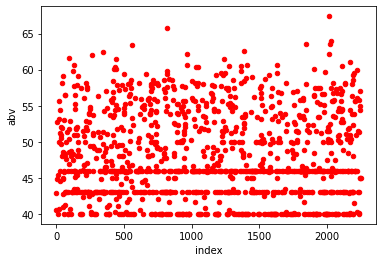

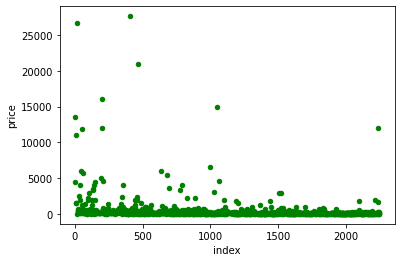

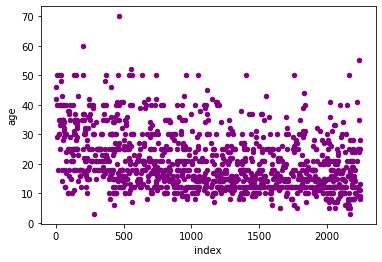

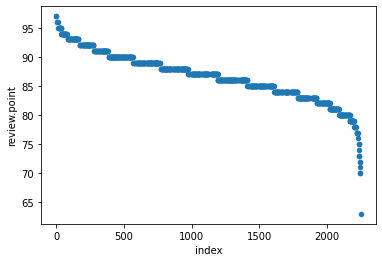

In [0]:
scotch.reset_index().plot.scatter(x='index', y='abv', color='red')
scotch.reset_index().plot.scatter(x='index', y='price', color='green')
scotch.reset_index().plot.scatter(x='index', y='age', color='purple')
scotch.reset_index().plot.scatter(x='index', y='review.point')

Na powyższych zestawieniach można zauważyć, że część danych odstaje znacznie od reszty. Wśród takich danych znajduje się na przykład bardzo wysoka cena sięgająca ponad 27000, gdzie średnia wartość nie przekracza 500, a mediana  1200. Usuwamy ze zbioru odstające dane.

#### Usuwanie odstających danych

Do wyznaczenia niepożądanych danych wykorzystamy wykres pudełkowy. Wszystkie wartości leżące poza wąsami o długości 4 IQR (rozstęp ćwiartkowy) uznajemy za odstające, a następnie usuwamy je z ramki danych.

Wyznaczamy pierwszy kwartyl, trzeci kwartyl i obliczamy rozstęp ćwiartkowy.

In [0]:
q1 = scotch.quantile(0.25)
q3 = scotch.quantile(0.75)
iqr = q3 - q1

In [0]:
iqr

review.point      6.0
price           150.0
age              13.0
abv               9.7
dtype: float64

Wyznaczamy wartości leżące poza wąsami wykresu pudełkowego. Długość wąsa ustalona została na `3*IQR` co oznacza, że odrzucone zostaną wartości nietypowe dla próby.

In [0]:
outliers = (scotch < (q1 - 3.0 * iqr)) | (scotch > (q3 + 3.0 * iqr))
outliers.sum()

abv              0
age              1
name             0
price           97
review.point     1
dtype: int64

Poniżej przedstawione zostały przykłady rekordów zawierających wartości odstające.

In [0]:
scotch[outliers.any(1)]

,name,review.point,price,age,abv
1,"Black Bowmore, 1964 vintage, 42 year old, 40.5%",97,4500.0,42.0,40.5
2,"Bowmore 46 year old (distilled 1964), 42.9%",97,13500.0,46.0,42.9
7,"Bowmore, 40 year old, 44.8%",96,11000.0,40.0,44.8
8,"The Dalmore, 50 year old, 52.8%",96,1500.0,50.0,52.8
11,"Macallan 1976 Vintage, 29 year old, cask #1135...",96,1500.0,29.0,45.4
...,...,...,...,...,...
2094,"BenRiach 40 year old, 50%",80,1800.0,40.0,50.0
2218,"Auchentoshan 1962, 41 year old, 40.3%",77,2000.0,41.0,40.3
2236,"The Macallan Lalique Decanter, 55 year old, 40.1%",74,12000.0,55.0,40.1
2237,"Signatory (distilled at Kinclaith), Cask #3014...",73,1700.0,35.0,51.3


Wykres pudełkowy prezentuje się następująco:

(0.0, 700.0)

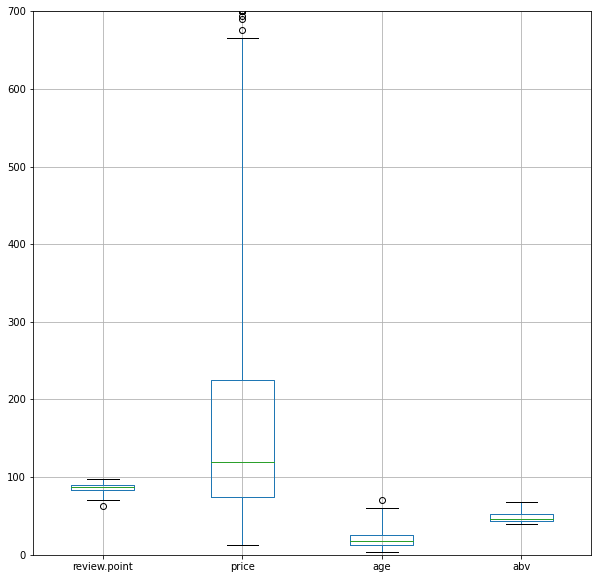

In [0]:
boxplot = scotch.boxplot(column=['review.point', 'price', 'age', 'abv'], figsize=(10, 10), whis=3)
boxplot.set_ylim([0, 700])

Usuwamy z ramki danych wyznaczone wartości odstające.

In [0]:
no_outliers = ~(outliers).any(axis=1)

scotch._update_inplace(scotch[no_outliers])
scotch.describe()

,review.point,price,age,abv
count,1095.000000,1095.000000,1095.000000,1095.000000
mean,86.378995,153.466667,19.180822,48.042091
std,3.995623,126.501456,8.359507,6.004217
min,70.000000,13.000000,3.000000,40.000000
25%,84.000000,70.000000,12.000000,43.000000
50%,87.000000,110.000000,18.000000,46.000000
75%,89.000000,180.000000,25.000000,52.850000
max,95.000000,665.000000,50.000000,67.400000


## Rozkład wartości

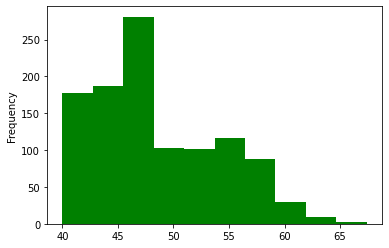

In [0]:
scotch['abv'].plot.hist(color='green')

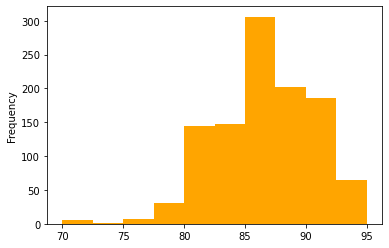

In [0]:
scotch['review.point'].plot.hist(color='orange')

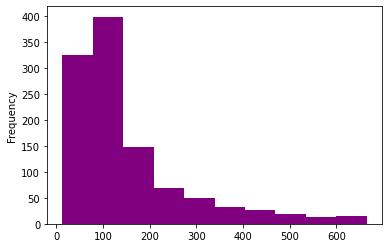

In [0]:
scotch['price'].plot.hist(color='purple')

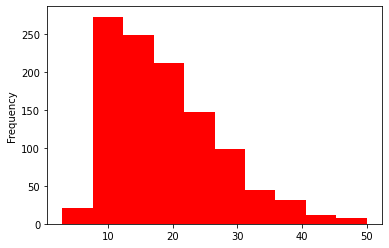

In [0]:
scotch['age'].plot.hist(color='red')

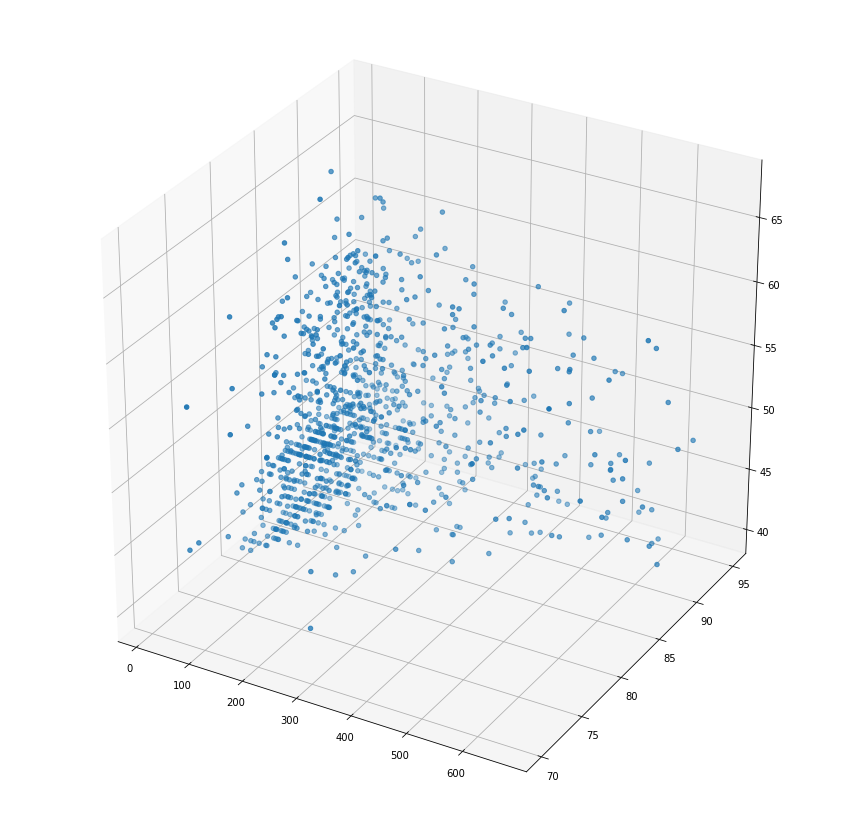

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

threedee = plt.figure(figsize=(15,15)).gca(projection='3d')
threedee.scatter(scotch['price'], scotch['review.point'], scotch['abv'])
plt.show()

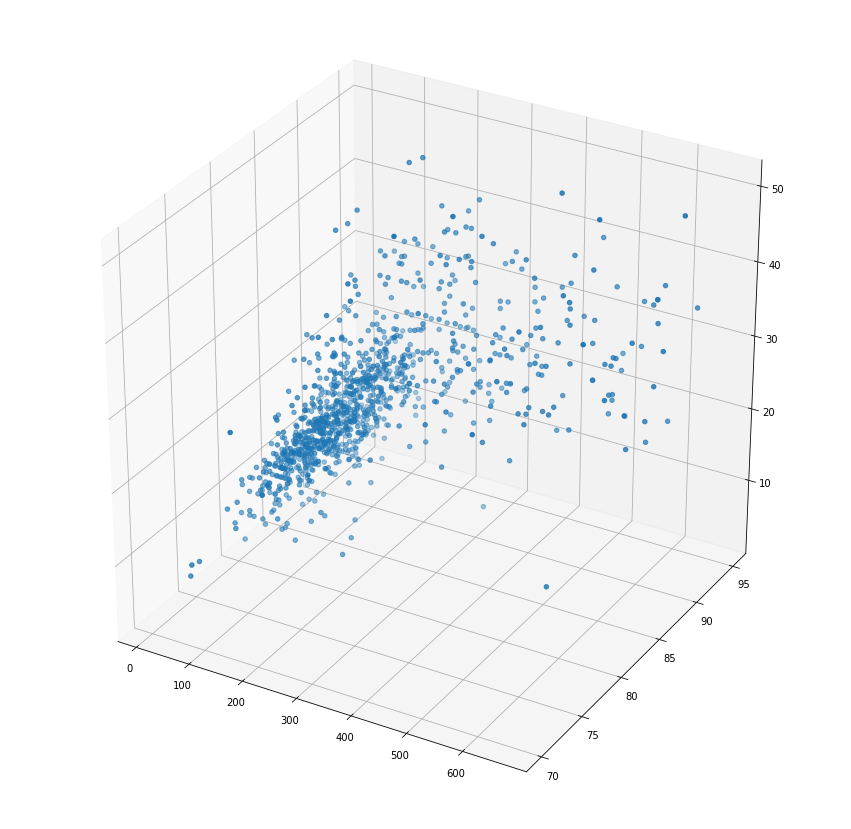

In [0]:
threedee = plt.figure(figsize=(15,15)).gca(projection='3d')
threedee.scatter(scotch['price'], scotch['review.point'], scotch['age'])
plt.show()

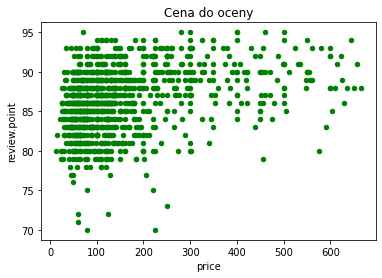

In [0]:
scotch.plot.scatter(x='price', y='review.point', title='Cena do oceny', color='green')

Z powyższego wykresu można zauważyć, że ocena jakości whisky nie ma mocnego powiązania z jego ceną. Wysokie noty sięgające 95 punktów zyskują zarówno alkohole z niższej półki jak i te z najwyższej. Można jednak zauważyć, że w przypadku drogich alkoholi, rzadkością są oceny poniżej 80 punktów.

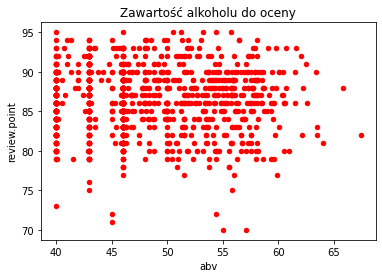

In [0]:
scotch.plot.scatter(x='abv', y='review.point', title='Zawartość alkoholu do oceny', color='red')

Na zestawieniu zawartości alkoholu w trunku oraz jego oceny nie widać żadnego powiązania.

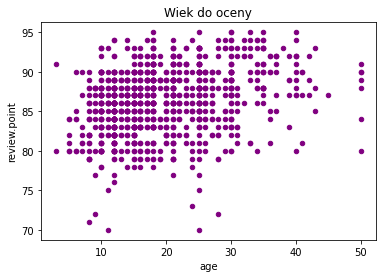

In [0]:
scotch.plot.scatter(x='age', y='review.point', title='Wiek do oceny', color='purple')

Wiek whisky wpływa pozytywnie na jego jakość jednak nie jest jedynym determinantem. Starsza whisky, powyżej 35 lat, osiąga głównie noty powyżej 85 punktów.

Macierz korelacji

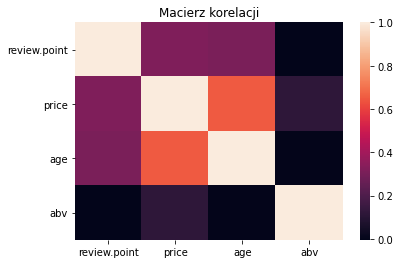

In [0]:
correlations = scotch.corr()

import seaborn as sns
ax = plt.axes()
sns.heatmap(correlations, xticklabels=correlations.columns, yticklabels=correlations.columns, ax=ax)
ax.set_title('Macierz korelacji')
plt.show()

Graficzna reprezentacja macierzy korelacji pokazuje nam, w jaki sposób poszczególne cechy oddziałują na siebie, można więc zauważyć, że najbardziej związane są ze sobą wiek oraz cena, natomiast słabe powiązania występują dla ceny i oceny oraz wieku i oceny whisky. Bardzo słaba zależność występuje również pomiędzy ceną a zawartością alkoholu, jednakże wartość jest na tyle niska, że nie warto brać jej pod uwagę w dalszej analizie.

## Klastrowanie

*Wykonujemy* kopie danych potrzebnych do wykonania klastrowania. Do analizy wykorzystamy cechy które wykazywały ze sobą związek: **wiek**, **cena** i **ocena**. 

In [0]:

clustering_data = scotch[['age', 'price', 'review.point']].copy()
clustering_data.head(5)

,age,price,review.point
16,18.0,70.0,95
21,30.0,400.0,95
23,30.0,400.0,95
27,40.0,460.0,95
30,33.0,280.0,95


### Agglomerative Clustering

W celu wybrania najlepszej liczby klastrów dla metody aglomeracyjnej zdecydowaliśmy się porównać dendrogramy uzyskane dla metod:
* Ward'a
* najbliższego sąsiedztwa (single)
* najdalszego sąsiedztwa (complete)
* średnich

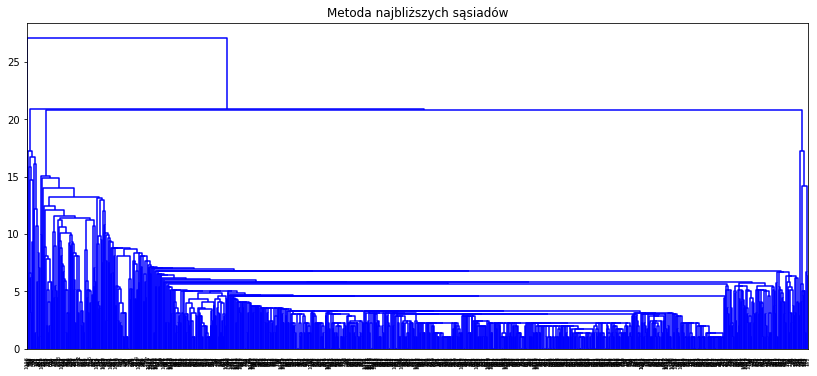

In [0]:
from scipy.cluster.hierarchy import dendrogram,linkage,fcluster

linkage_matrix=linkage(clustering_data,'single')
plt.figure(figsize=(14,6))
dendrogram(linkage_matrix,color_threshold=0)
plt.title('Metoda najbliższych sąsiadów')
plt.show()

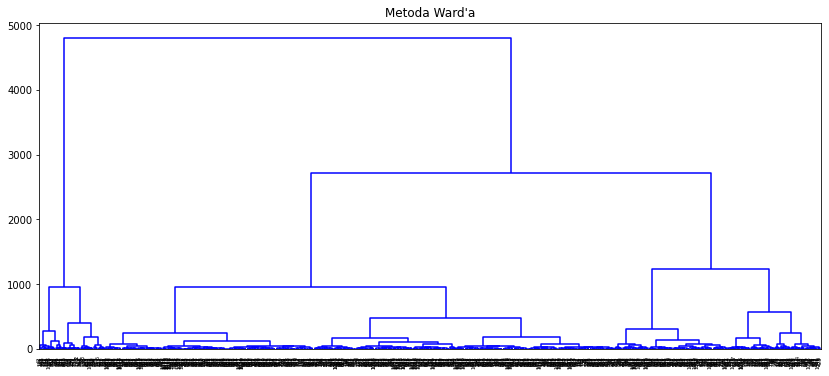

In [0]:
linkage_matrix=linkage(clustering_data,'ward')
plt.figure(figsize=(14,6))
dendrogram(linkage_matrix,color_threshold=0)
plt.title('Metoda Ward\'a')
plt.show()

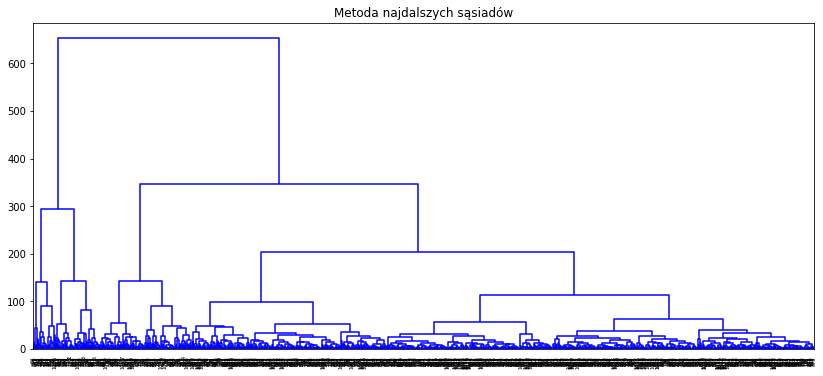

In [0]:
linkage_matrix=linkage(clustering_data,'complete')
plt.figure(figsize=(14,6))
dendrogram(linkage_matrix,color_threshold=0)
plt.title('Metoda najdalszych sąsiadów')
plt.show()

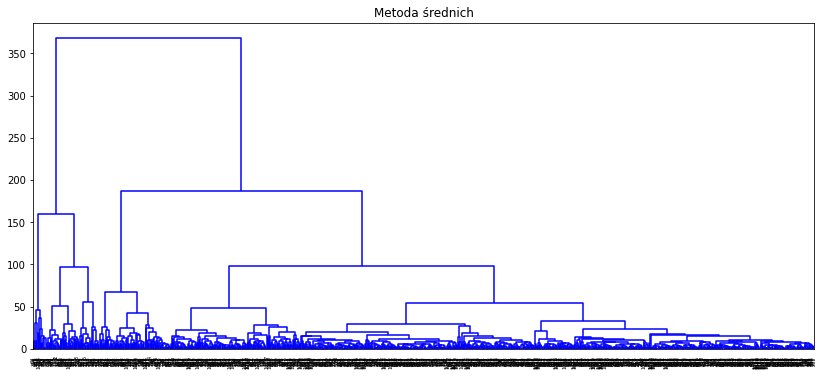

In [0]:
linkage_matrix=linkage(clustering_data,'average')
plt.figure(figsize=(14,6))
dendrogram(linkage_matrix,color_threshold=0)
plt.title('Metoda średnich')
plt.show()

Analizując powstałe dendrogramy, można zauważyć, że metoda najbliższego sąsiedztwa (single) dała najgorsze wyniki, natomiast wyniki uzyskane dla metod Ward'a, najdalszego sąsiedztwa (complete) oraz średnich są dość zbliżone. Do dalszej analizy postanowiliśmy wykorzystać metodę Ward'a z podziałem na 3 klastry, ponieważ dzięki temu uzyskujemy najlepszy podział na klasy.

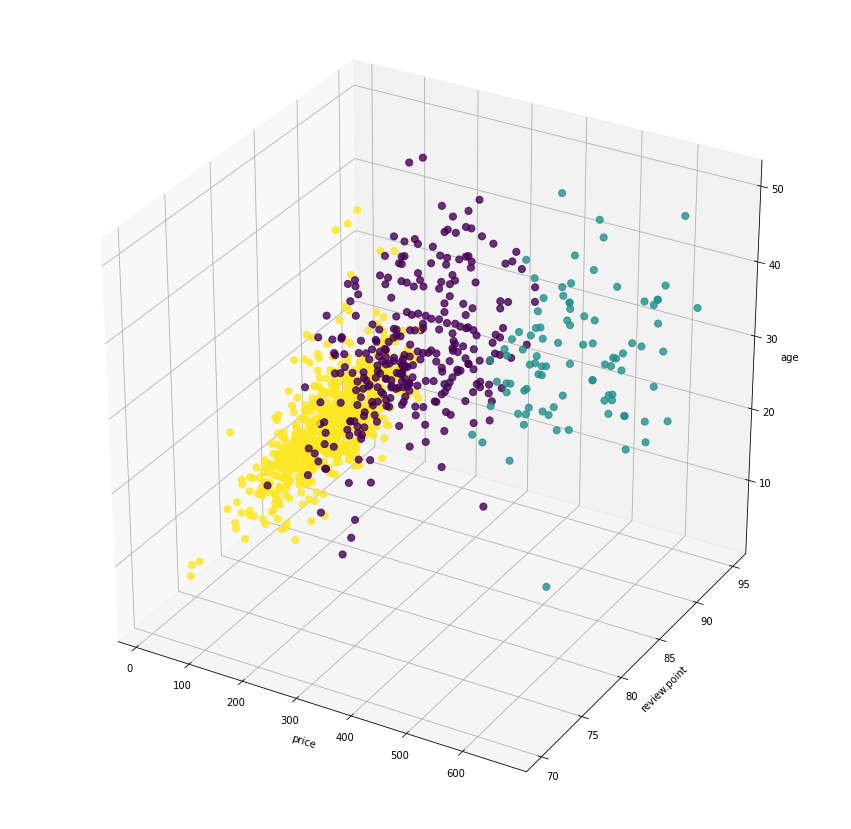

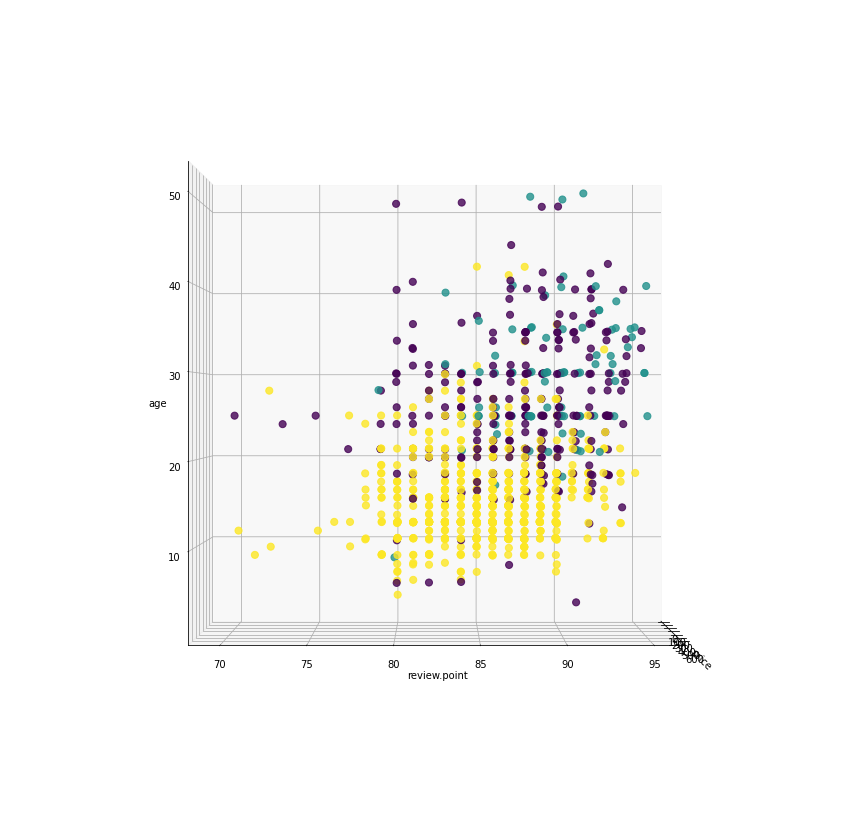

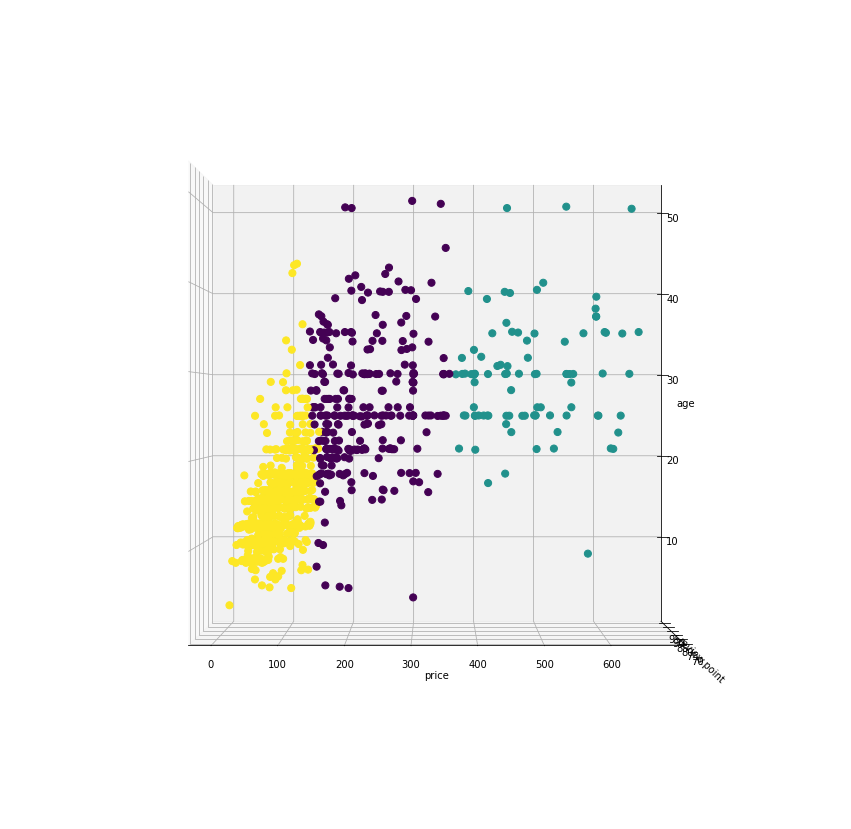

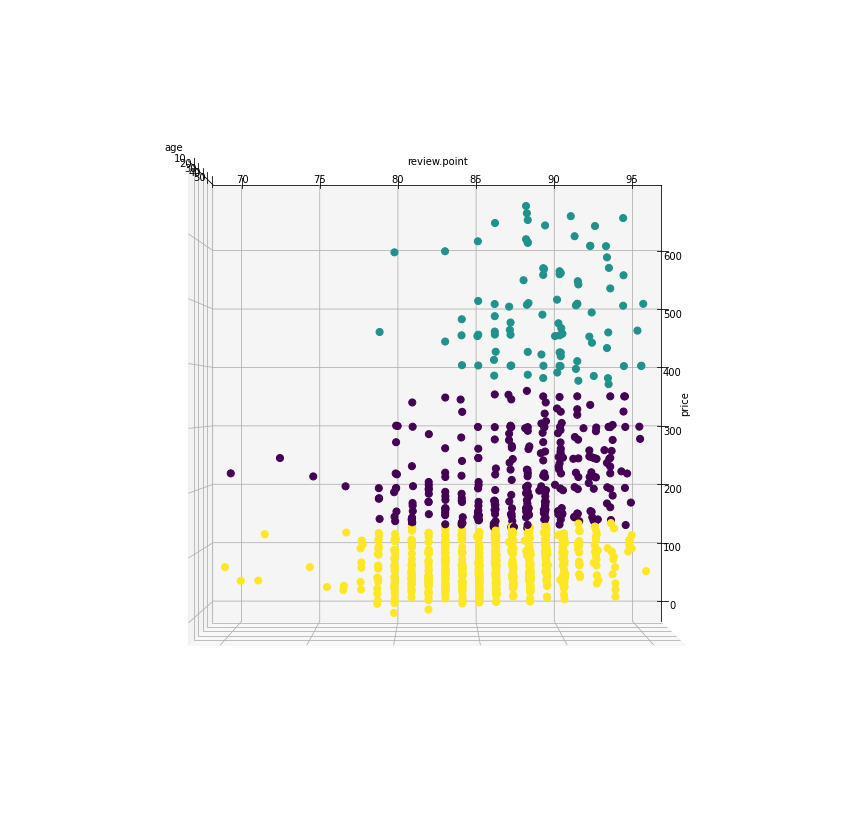

In [0]:
from sklearn.cluster import AgglomerativeClustering

hc = AgglomerativeClustering(n_clusters=3).fit(clustering_data)
threedee = plt.figure(figsize=(15,15)).gca(projection='3d')
threedee.set_xlabel("price")
threedee.set_ylabel("review.point")
threedee.set_zlabel("age")
threedee.scatter(scotch['price'], scotch['review.point'], scotch['age'], c=hc.labels_.astype(float), s=50, alpha=.8)

threedee = plt.figure(figsize=(15,15)).gca(projection='3d')

threedee.set_xlabel("price")
threedee.set_ylabel("review.point")
threedee.set_zlabel("age")
threedee.view_init(0, 00)
threedee.scatter(scotch['price'], scotch['review.point'], scotch['age'], c=hc.labels_.astype(float), s=50, alpha=.8)

threedee = plt.figure(figsize=(15,15)).gca(projection='3d')
threedee.set_xlabel("price")
threedee.set_ylabel("review.point")
threedee.set_zlabel("age")
threedee.view_init(0, -90)
threedee.scatter(scotch['price'], scotch['review.point'], scotch['age'], c=hc.labels_.astype(float), s=50, alpha=1)
plt.show()

threedee = plt.figure(figsize=(15,15)).gca(projection='3d')
threedee.set_xlabel("price")
threedee.set_ylabel("review.point")
threedee.set_zlabel("age")
threedee.view_init(-90, 0)
threedee.scatter(scotch['price'], scotch['review.point'], scotch['age'], c=hc.labels_.astype(float), s=50, alpha=1)
plt.show()

In [0]:
linkage_matrix=linkage(clustering_data,'ward')
class_number=fcluster(linkage_matrix,t=3,criterion='maxclust')
centers_new=clustering_data.groupby(class_number).mean()
centers_new_df=pd.DataFrame(centers_new)
centers_new_df.columns=clustering_data.columns
centers_new_df

,age,price,review.point
1,29.731183,489.784946,89.204301
2,15.008403,83.742297,85.570028
3,26.118056,217.722222,87.472222


Z podziału na 3 klastry uzyskaliśmy klasy widoczne w tabeli ponizej.

|  Nazwa Klasy              |   Wiek      | Cena    | Ocena                  |
|---------------------------|:-----------:|:-------:|:----------------------:|
| Tanie i młode             | Młody       | Niska   | Dobra / Bardzo dobra.  |
| Średnio drogie i dojrzałe | Dojrzały    | Średnia | Bardzo dobra           |
| Premium                   | Dojrzały    | Wysoka  | Bardzo dobra / Wybitna |

Jak można zauważyć, wcale nie trzeba szukać drogiej Whisky, wartej kilkaset dolarów, aby degustować trunek uznawany za dobry lub bardzo dobry. Gdybyśmy za cel ustanowili, odszukanie dobrej i starej Whisky również nie musimy wydać na niej olbrzymiej sumy, ponieważ w okolicach 200 dolarów, możemy znaleźć stary oraz dojrzały alkohol. O ile średnia ocen pomiędzy klasami nie zmienia się znacząco, to cena pomiędzy klasami może zmieniać się drastycznie, aż o kilkaset dolarów. Co istotne należy zwrócić uwagę, na związek wieku Whisky oraz smaku, jak można zauważyć, nawet kilkanaście lat dojrzewania więcej, nie wpływa znacząco na jej smak.

### K-Means Clustering

W celu wybrania najlepszego podziału na klastry dla metody K-średnich, wybraliśmy poniższe metryki do analizy: 
* Inercja
* Silhoutte
* Callinski-Harabasz

In [0]:
from sklearn.cluster import KMeans
from sklearn import metrics
import numpy as np

inertia_scores = []
silhouette_scores = []
callinski_harabas = []
sample_clusters = np.arange(2, 40)
for n_clusters in sample_clusters:
  kmeans = KMeans(n_clusters=n_clusters).fit(clustering_data)
  inertia_scores.append(kmeans.inertia_)
  silhouette_scores.append(metrics.silhouette_score(clustering_data, kmeans.labels_))
  callinski_harabas.append(metrics.calinski_harabasz_score(clustering_data, kmeans.labels_))

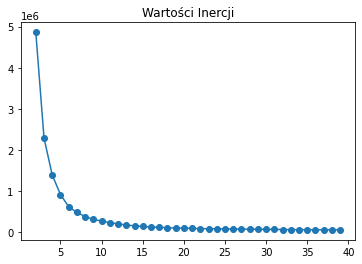

In [0]:
plt.scatter(x=sample_clusters, y=inertia_scores)
plt.plot(sample_clusters, inertia_scores)
plt.title('Wartości Inercji')
plt.show()

W celu znalezienia optymalnej liczby podziałów na klastry przy pomocy wartości inercji, szukamy wartości dla której suma warjancji przestaje gwałtownie maleć.
W przypadku uzyskanych wyników tą liczbą jest **n_clusters=5**.

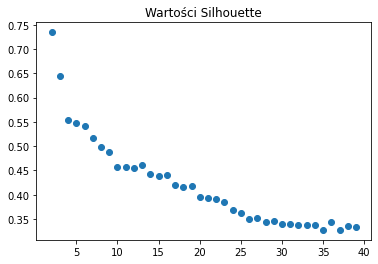

In [0]:
plt.scatter(x=sample_clusters, y=silhouette_scores)
plt.title('Wartości Silhouette')
plt.show()

Dla metryki Shilhouetta, najlepsza liczba podziału zostanie osiągnięta im wartość jest bliższa liczbie 1. W naszym przypadku to liczba **n_clusters=2**.

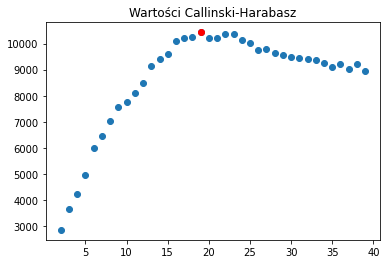

In [0]:
plt.scatter(x=sample_clusters, y=callinski_harabas)
ch_max = max(callinski_harabas)
ch_x = callinski_harabas.index(ch_max)
plt.plot(sample_clusters[ch_x], ch_max, "or")
plt.title('Wartości Callinski-Harabasz')
plt.show()

Dla metryki Callinskiego-Harabasza, najlepsza liczba podziału zostanie osiągnięta dla ekstremum wykresu. W naszym przypadku najwyższą wartość metryka osiągnęła dla liczby **n_clusters=21**.

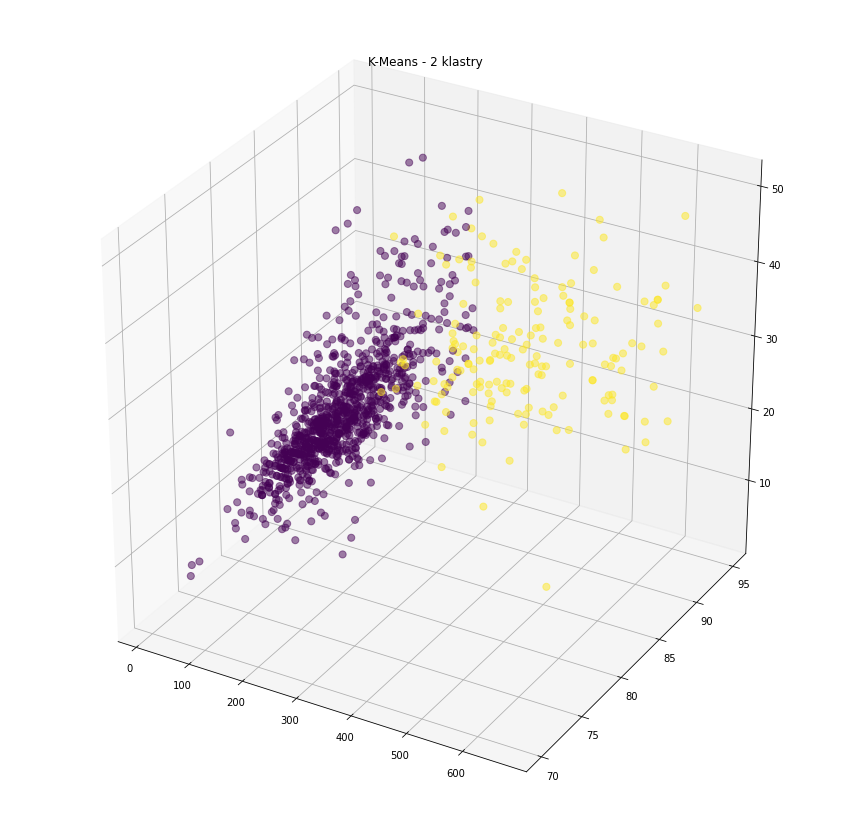

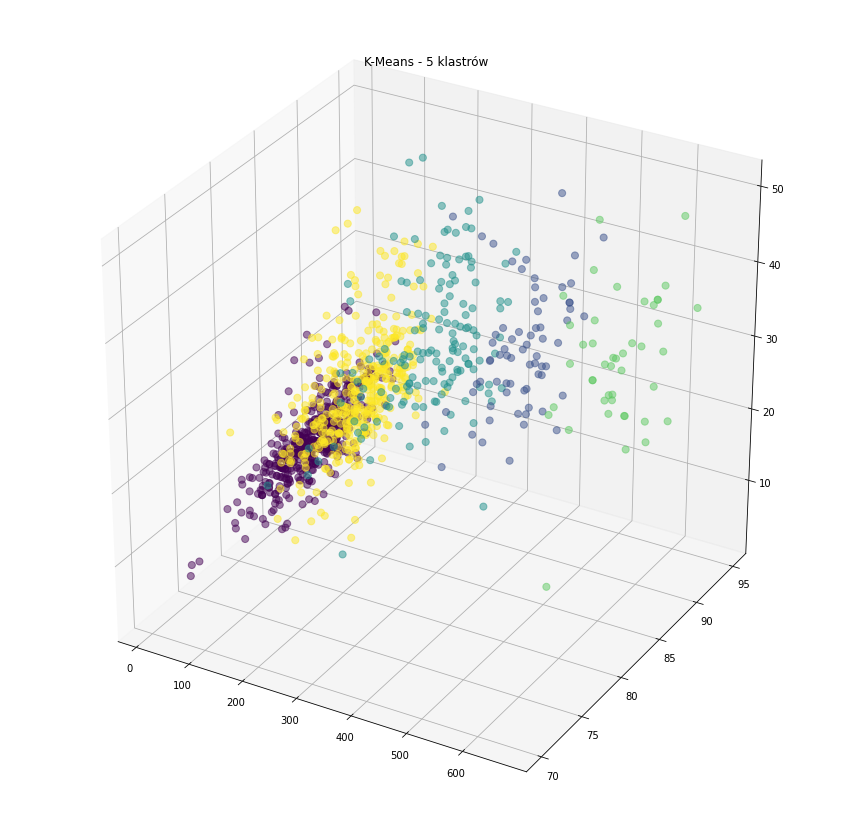

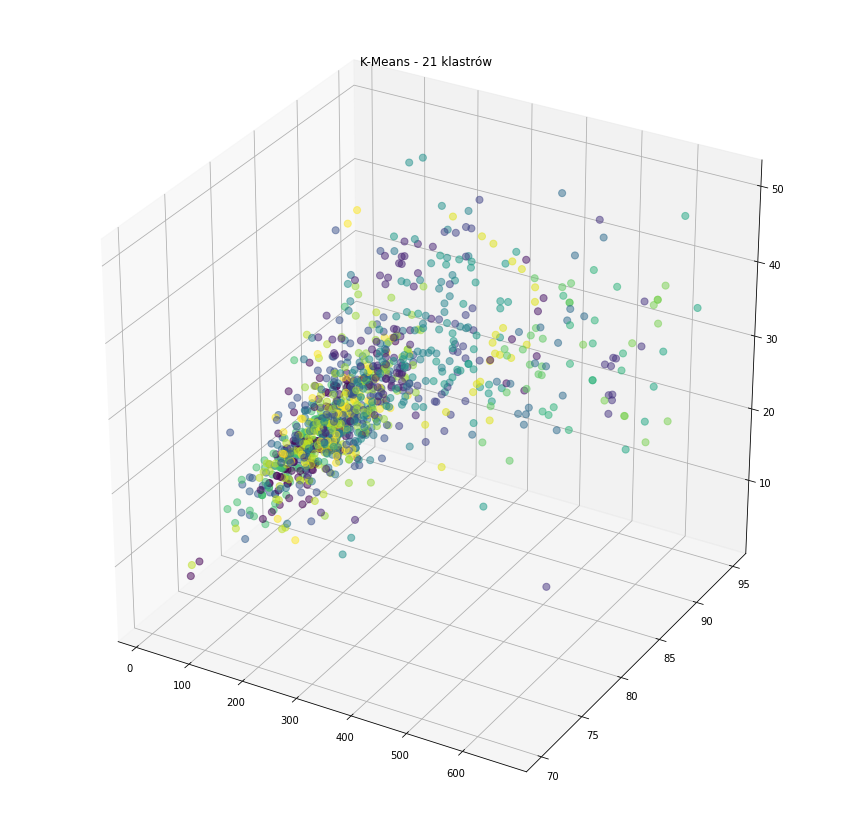

In [0]:
kmeans = KMeans(n_clusters=2).fit(clustering_data)
threedee = plt.figure(figsize=(15,15)).gca(projection='3d')
threedee.scatter(scotch['price'], scotch['review.point'], scotch['age'], c= kmeans.labels_.astype(float), s=50, alpha=0.5)
plt.title('K-Means - 2 klastry')
plt.show()

kmeans = KMeans(n_clusters=5).fit(clustering_data)
threedee = plt.figure(figsize=(15,15)).gca(projection='3d')
threedee.scatter(scotch['price'], scotch['review.point'], scotch['age'], c= kmeans.labels_.astype(float), s=50, alpha=0.5)
plt.title('K-Means - 5 klastrów')
plt.show()

kmeans = KMeans(n_clusters=21).fit(clustering_data)
threedee = plt.figure(figsize=(15,15)).gca(projection='3d')
threedee.scatter(scotch['price'], scotch['review.point'], scotch['age'], c= kmeans.labels_.astype(float), s=50, alpha=0.5)
plt.title('K-Means - 21 klastrów')
plt.show()

Analizując rozkłady wartości w poszczególnych klastrach, najlepszą liczbą podziałów jest **5**, gdyż taka liczba klastrów pozwala na uzyskanie klas które są wyraźnie zarysowane na wykresie i w małym stopniu nakładają się na siebie.

In [0]:
kmeans = KMeans(n_clusters=5).fit(clustering_data)
kmeans_centers = pd.DataFrame(kmeans.cluster_centers_)
kmeans_centers.rename(columns={0: 'age', 1:'price', 2:'review.point'})

,age,price,review.point
0,19.844388,129.489796,86.392857
1,29.420290,400.507246,88.840580
2,27.217105,244.703947,87.888158
3,13.079909,63.216895,85.130137
4,30.181818,562.886364,89.613636


## Wnioski

W przypadku metody aglomeracyjnej optymalną liczbę podziałów na klastry uzyskaliśmy analizując utworzone dendrogramy. Metoda Ward'a jasno zarysowała podział na 3 klastry, jednakże należy zauważyć, że uzyskana liczba zależy od interpretacji danego drzewa.


W przypadku metody K-średnich, wyniki otrzymane przy poszukiwaniu optymalnej liczby podziałów okazały się bardzo rozbieżne. W celu wybrania odpowiedniej wartości pomocne była wizualizacja powstałych klas przy pomocy wykresów. Za najlepszą liczbę podziałów dla tej metody uznaliśmy 5, gdyż przy takiej liczbie podziałów powstały jasno zarysowane klasy o uwydatnionych cechach. W przypadku podziału na 2 klastry powstałe klastry są zbyt ogólne, a przy podziale na 21 klastrów, brak jest widocznego podziału na klasy.

Biorąc pod uwagę wyniki uzyskane przy poszukiwaniu najlepszej liczby podziałów dla metod Aglomeracyjnej i K-Means, dla naszego zbioru danych, lepsza okazała się pierwsza metoda. Metody podziału Ward'a, średnich oraz najdalszych sąsiadów, utworzyły zbliżone drzewa, dla których ta sama liczba podziałów byłaby optymalna.

Podsumowując uzyskane wyniki analizy, można zauważyć tendencję wzrostową względem jakości smaku a wiekiem. Przy wyższych rocznikach Whisky (około 30 lat) zanikają produkty o niskiej jakości, jednakże minimalny wzrost średniej oceny wiąże się ze znacznym wzrostem ceny trunku. 

Porównując wyniki uzyskane dla metody K-Means oraz rozkład wartości cen Whisky, można wywnioskować, że już za około 250 dolarów, możemy zakupić bardzo dobry alkohol. Ponieważ klasa odpowiadająca temu przedziałowi cenowemu posiada bardzo dobre noty dotyczące smaku oraz dla tej ceny występuje bardzo dobrze widoczny przeskok liczby dostępnych produktów, co może oznaczać koniec produkcji masowej, a ukierunkowanie się na węższe grono odbiorców, poszukujących trunków wyższej jakości. 

